<a href="https://colab.research.google.com/github/Alenushka2013/ML_for_people_tasks/blob/main/HW_2_4_kNN_Cross_validation_and_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [1]:
!wget https://raw.githubusercontent.com/Alenushka2013/ML_for_people_tasks/refs/heads/main/process_bank_churn.py

--2025-07-14 11:59:30--  https://raw.githubusercontent.com/Alenushka2013/ML_for_people_tasks/refs/heads/main/process_bank_churn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5943 (5.8K) [text/plain]
Saving to: ‘process_bank_churn.py’

process_bank_churn. 100%[===================>]   5.80K  --.-KB/s    in 0s      

2025-07-14 11:59:30 (46.2 MB/s) - ‘process_bank_churn.py’ saved [5943/5943]



In [2]:
from process_bank_churn import preprocess_data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

raw_df = pd.read_csv('https://raw.githubusercontent.com/Alenushka2013/Coursera/refs/heads/master/Datasets/bank-customer-churn-prediction.csv', index_col=0)

data = preprocess_data(raw_df, scale_numeric=True)

X_train = data['X_train']
train_targets = data['y_train']
X_val = data['X_val']
val_targets = data['y_val']

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [4]:
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [5]:
def auroc_train_and_val(model, X_train, X_val, train_targets, val_targets):

  train_probs = model.predict_proba(X_train)
  val_probs = model.predict_proba(X_val)

  # рахуємо ROC-криві
  fpr_train, tpr_train, _ = roc_curve(train_targets, train_probs[:, 1])
  fpr_val, tpr_val, _ = roc_curve(val_targets, val_probs[:, 1])

  # обчислюємо AUC
  auc_train = roc_auc_score(train_targets, train_probs[:, 1])
  auc_val = roc_auc_score(val_targets, val_probs[:, 1])

  # будуємо графік
  plt.figure(figsize=(8, 6))
  plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.4f})")
  plt.plot(fpr_val, tpr_val, label=f"Validation ROC (AUC = {auc_val:.4f})")
  plt.plot([0, 1], [0, 1], linestyle='--', color='green')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()

In [6]:
# Функція, щоб передбачати  значення і рахувати метрики
def predict_and_plot(model, inputs, targets, name=''):
    pred_prob = model.predict_proba(inputs)
    predict = model.predict(inputs)
    # roc_auc = roc_auc_score(targets, pred_prob[:, 1])
    # print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    confusion_matrix_ = confusion_matrix(targets,predict, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()

    # Звіт про класифікацію
    #print(classification_report(targets, predict))

    report = classification_report(targets, predict, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Printing with 3 decimal places
    print(df_report.round(3))

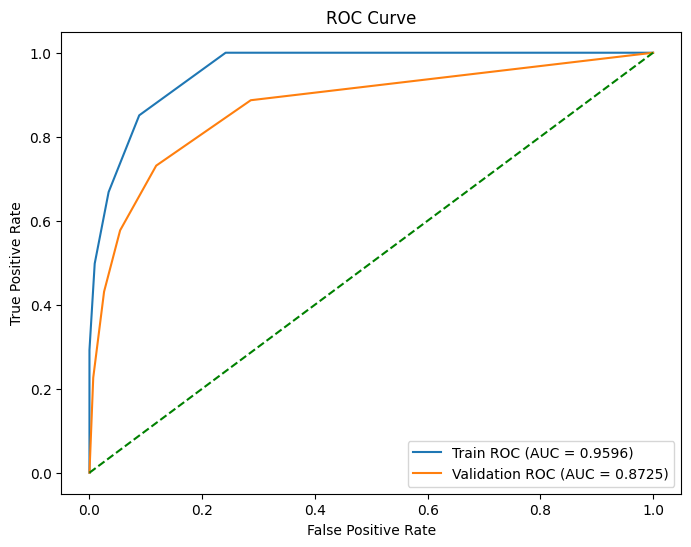

In [7]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)
auroc_train_and_val(knn, X_train, X_val, train_targets, val_targets)

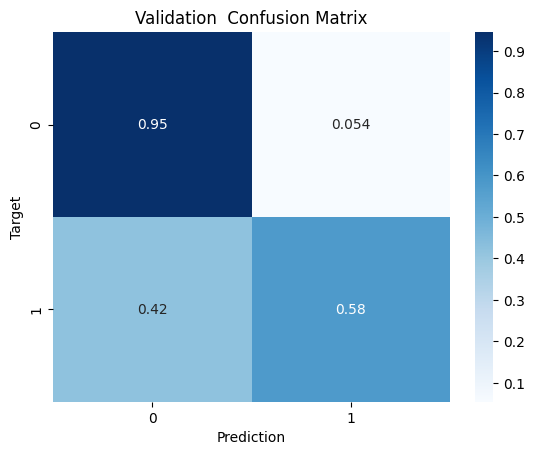

              precision  recall  f1-score   support
0.0               0.898   0.946     0.921  2390.000
1.0               0.730   0.577     0.645   610.000
accuracy          0.871   0.871     0.871     0.871
macro avg         0.814   0.761     0.783  3000.000
weighted avg      0.864   0.871     0.865  3000.000


In [8]:
predict_and_plot(knn, X_val, val_targets, name='Validation ')

**Висновки:**

Значна різниця в значеннях точності  AUROC на тренувальному та валідаційному наборах свідчить про перенавчання, така модель не підходить для використання.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Поставте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [9]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)
print('Найкраще значення параметра', knn_gs.best_params_)

Найкраще значення параметра {'n_neighbors': np.int64(7)}


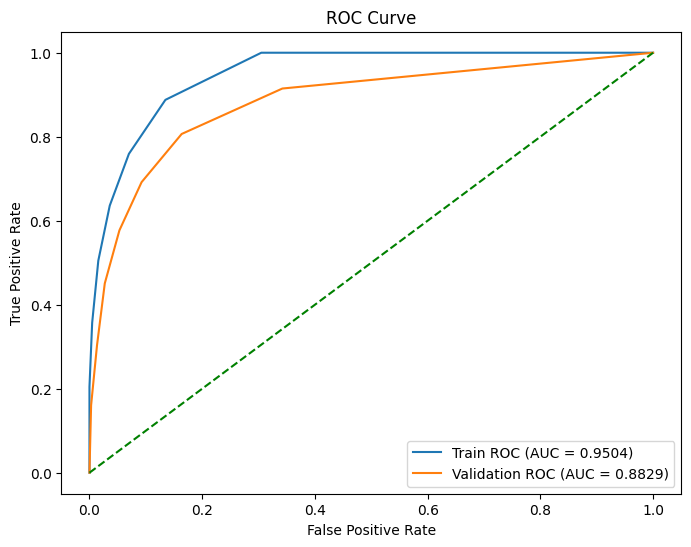

In [10]:
knn_best = knn_gs.best_estimator_
auroc_train_and_val(knn_best, X_train, X_val, train_targets, val_targets)

**Висновки:**

Показники AUROC трохи покращилися, але все досить велика різниця в значеннях точності  на тренувальному та валідаційному наборах свідчить про перенавчання, тому і ця модель не підходить для використання.

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [11]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)
params_tree = {'max_depth': np.arange(1, 20),
          'max_leaf_nodes': np.arange(2, 20)}
tree_gs = GridSearchCV(tree, params_tree, cv=3, scoring='roc_auc')
tree_gs.fit(X_train, train_targets)
print('Найкращі значення параметрів', tree_gs.best_params_)

Найкращі значення параметрів {'max_depth': np.int64(6), 'max_leaf_nodes': np.int64(19)}


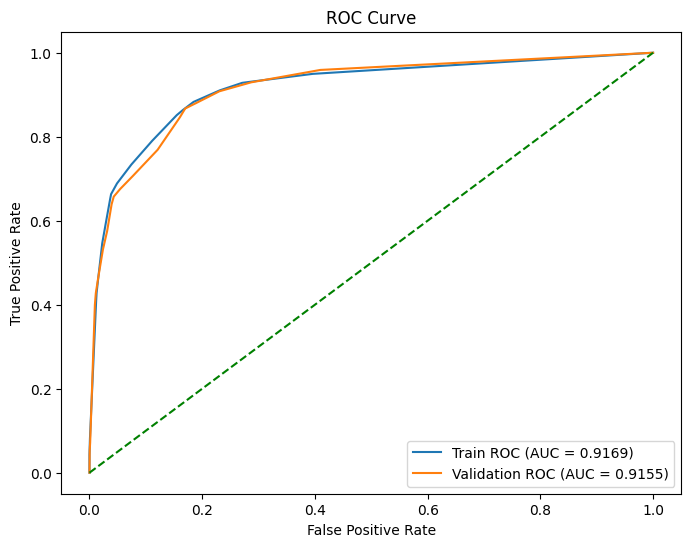

In [12]:
tree_best = tree_gs.best_estimator_
auroc_train_and_val(tree_best, X_train, X_val, train_targets, val_targets)

**Висновки:**

Показники AUROC покращилися та близькі за значеннями на тренувальному та валідаційному наборах, тому на даний момент це найкраща модель.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [19]:
from sklearn.model_selection import RandomizedSearchCV
tree = DecisionTreeClassifier(random_state = 42)
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}
random_search = RandomizedSearchCV(
    tree,
    params_dt,
    n_iter = 40,
    cv=3,
    scoring='roc_auc',
    refit=True
    )

In [20]:
%%time
tree_search = random_search.fit(X_train, train_targets)

CPU times: user 1.81 s, sys: 5.93 ms, total: 1.82 s
Wall time: 1.83 s


In [21]:
print('Найкращі значення параметрів', tree_search.best_params_)

Найкращі значення параметрів {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': np.int64(19), 'max_features': None, 'max_depth': np.int64(13), 'criterion': 'entropy'}


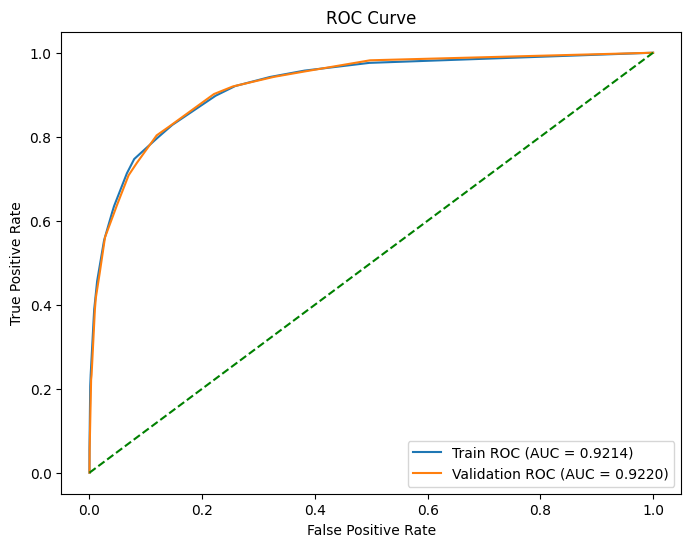

In [22]:
dt_random_search_best = tree_search.best_estimator_
auroc_train_and_val(dt_random_search_best, X_train, X_val, train_targets, val_targets)

**Висновки:**

Показники AUROC для RandomizedSearchCV трохи краще ніж для GridSearch, але для цієї моделі наявна певна випадковість. Запустивши код кілька разів, навіть з фіксованим random_state можна отримати різні значення.

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [17]:
from process_bank_churn import preprocess_new_data

test_raw_df = pd.read_csv('/content/test.csv')
test_raw_df = preprocess_new_data(test_raw_df, data['data_cols'], data['scaler'], data['encoder'])
X_test_predict = dt_random_search_best.predict_proba(test_raw_df)

In [23]:
df_sample = pd.read_csv('/content/sample_submission.csv')
df_sample['Exited'] = X_test_predict[:, 1]
df_sample.to_csv('/content/submission_tree_random_search.csv', index=False)

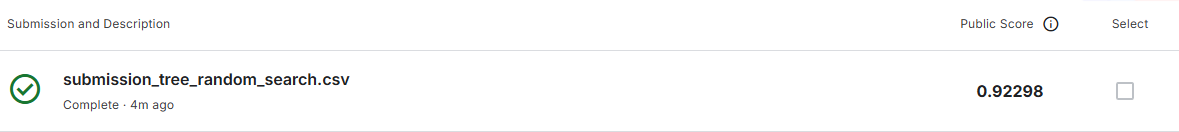

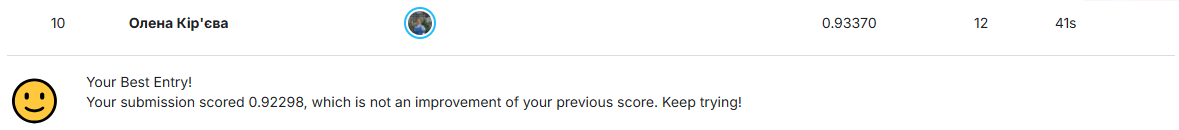

Скор на паблік лідерборді не від цієї моделі :)